In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as msno

In [7]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


<AxesSubplot:>

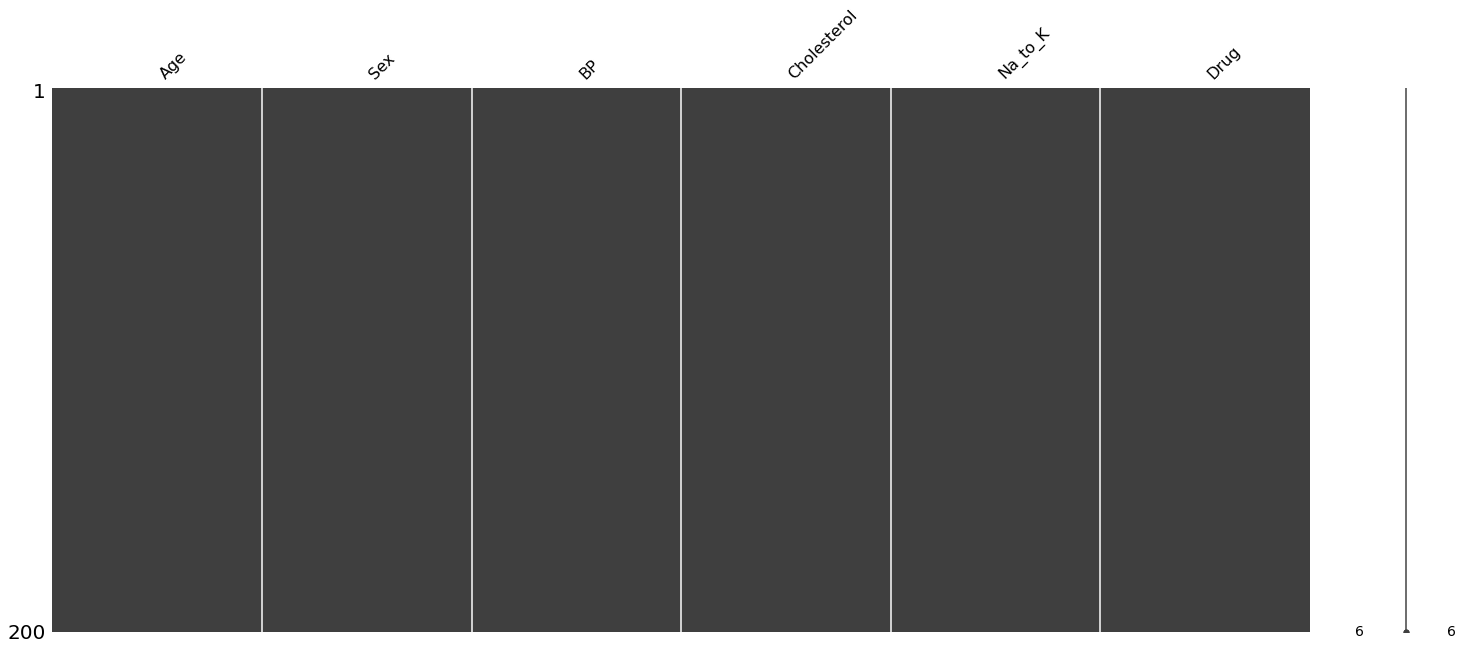

In [10]:
msno.matrix(df) # check for NaN values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


# EDA

<AxesSubplot:>

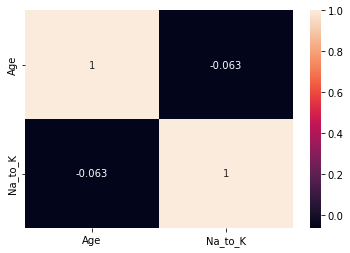

In [14]:
sns.heatmap(data=df.corr(), annot=True)

In [18]:
df.Cholesterol.unique()

array(['HIGH', 'NORMAL'], dtype=object)

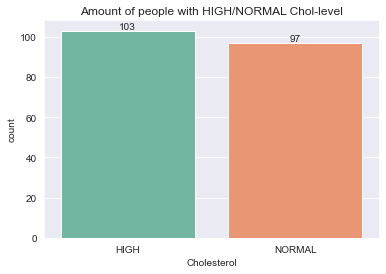

In [30]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
ax = sns.countplot(data=df, x='Cholesterol')
ax.bar_label(ax.containers[0]) 
plt.title('Amount of people with HIGH/NORMAL Chol-level')

plt.show()

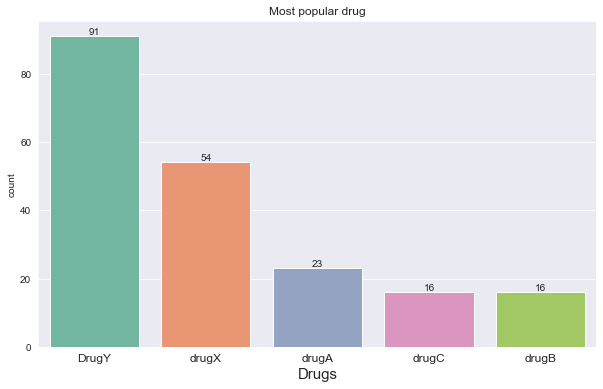

In [47]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='Drug', order=df.Drug.value_counts().index)
ax.bar_label(ax.containers[0])
plt.xlabel('Drugs', fontsize=15)
plt.xticks(fontsize=12)
plt.title('Most popular drug')
plt.show()

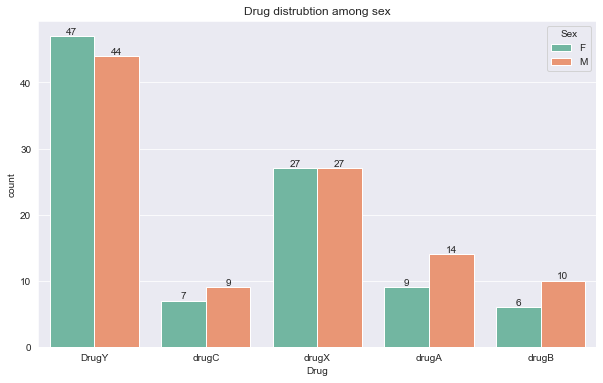

In [66]:
plt.figure(figsize=(10,6))

ax = sns.countplot(data=df, x='Drug', hue='Sex')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])


plt.title('Drug distrubtion among sex')
plt.show()

In [71]:
gp = df.groupby(['Drug','Sex'])[['Age']].mean().reset_index()

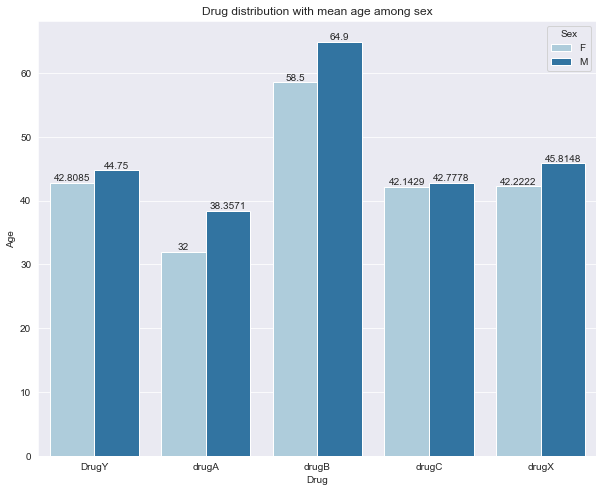

In [79]:
plt.figure(figsize=(10,8))
sns.set_palette('Paired')

ax = sns.barplot(data=gp, x='Drug', y='Age', hue='Sex')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])


plt.title('Drug distribution with mean age among sex')
plt.show()

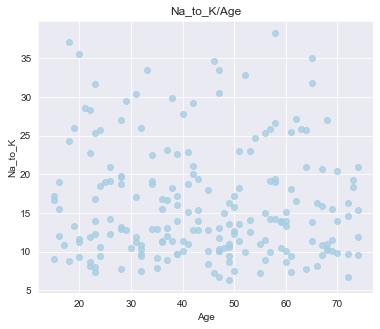

In [179]:
plt.figure(figsize=(6,5))
plt.title('Na_to_K/Age')
sns.regplot(data=df, x='Age', y='Na_to_K', fit_reg=False)
plt.show()

# People with higher Na_to_K than 20-25 is rare, and does not have any effects on the age.

## Analysis
* There's no difference in Cholesterol level between the people in the dataset
* Most popular drug is DrugY and DrugX, and there's no clearly difference between sex among these
* Older people tend to have drugB and the biggest age difference is between drugA and drugB so age its not an important feature

## train test split and features importance

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

In [106]:
# target variable
target = 'Drug'
y = df[target]
X = df.drop(target, axis=1)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=(1/3)) 

# preprocessing 

# numerical columns
num_features = X.select_dtypes('number').columns
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

# categorical columns
cat_features = ['Sex', 'BP', 'Cholesterol']
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                OneHotEncoder(handle_unknown='error', drop='if_binary'))

preprocessing = make_column_transformer((num_transformer, num_features), (cat_transformer, cat_features))


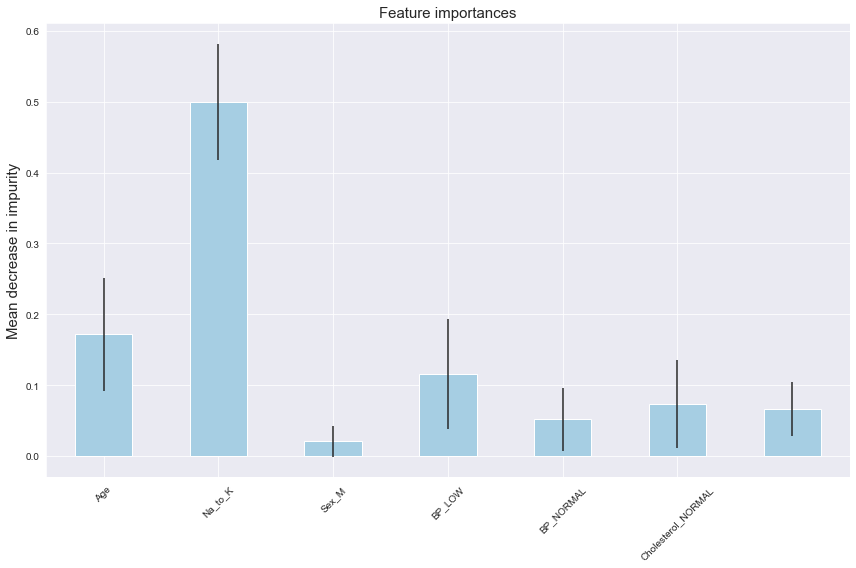

In [137]:
X1_1 = pd.get_dummies(data = X, columns=['Sex', 'BP', 'Cholesterol'], drop_first=True)
feature_names = X1_1.columns

forest = RandomForestClassifier(random_state=42)
pipe = make_pipeline(preprocessing, forest)
pipe.fit(X_train, y_train)


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


forest_importances = pd.Series(importances)

fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances", fontsize=15)
ax.set_ylabel("Mean decrease in impurity", fontsize=15)
plt.xticks(range(X1_1.shape[1]), feature_names)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

# Model selection, evaluate different classification algorithm with Cross-validation

In [146]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

classifiers = [SVC(),
              LogisticRegression(),
              SGDClassifier(), 
              GaussianNB(),
              KNeighborsClassifier(),
              RandomForestClassifier()]

for algo in classifiers:
    pipe = make_pipeline(preprocessing, algo)
    grid = GridSearchCV(estimator = pipe,
                        param_grid = {},
                        cv=10,
                       scoring = 'accuracy')
    grid.fit(X_train, y_train)
    score = grid.best_score_
    
    print(f'best score {score} with algorithm {algo}\n')
    

best score 0.9318681318681319 with algorithm SVC()

best score 0.953846153846154 with algorithm LogisticRegression()

best score 0.9538461538461538 with algorithm SGDClassifier()

best score 0.682967032967033 with algorithm GaussianNB()

best score 0.8263736263736264 with algorithm KNeighborsClassifier()

best score 0.9846153846153847 with algorithm RandomForestClassifier()



## Hypertuning parameter on RandomForest

In [157]:
forest = RandomForestClassifier()

pipe = make_pipeline(preprocessing, forest)

# parameter tuning 
param_grid = {'randomforestclassifier__n_estimators' : [100,200, 300, 500],
              'randomforestclassifier__min_samples_split': [2,3,5]
              }

grid = GridSearchCV(estimator = pipe,
                    param_grid = param_grid,
                    cv = 10,
                    scoring = 'accuracy',
                   error_score='raise')

grid.fit(X_train, y_train)
print(f'Best score: {grid.best_score_}\n Best parameter: {grid.best_params_}')

Best score: 0.9923076923076923
 Best parameter: {'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 100}


## Evaulation on test data 

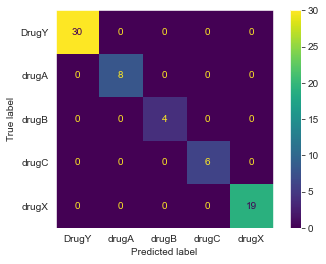

In [170]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
pred = grid.predict(X_test)
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_).plot()
plt.grid(None)
plt.show()

In [165]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred) # 100% accuracy score 

1.0